In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_median
import numpyro_glm.logistic.models as glm_logistic
import pandas as pd
from scipy.stats import beta
import seaborn as sns

numpyro.set_host_device_count(4)

# Exercise 21.3

In [3]:
batting_df: pd.DataFrame = pd.read_csv('datasets/BattingAverage.csv')
batting_df['PriPos'] = batting_df['PriPos'].astype('category')
batting_df['Player'] = batting_df['Player'].astype('category')
batting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Player        948 non-null    category
 1   PriPos        948 non-null    category
 2   Hits          948 non-null    int64   
 3   AtBats        948 non-null    int64   
 4   PlayerNumber  948 non-null    int64   
 5   PriPosNumber  948 non-null    int64   
dtypes: category(2), int64(4)
memory usage: 72.6 KB


In [4]:
kernel = NUTS(glm_logistic.binom_one_nominal_predictor_het,
              init_strategy=init_to_median)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(batting_df['Hits'].values),
    grp=jnp.array(batting_df['PriPos'].cat.codes.values),
    N=jnp.array(batting_df['AtBats'].values),
    nb_groups=batting_df['PriPos'].cat.categories.size,
)
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
            _a[0]      0.09      0.14      0.10     -0.12      0.33    437.78      1.01
            _a[1]      0.07      0.14      0.08     -0.16      0.29    442.18      1.01
            _a[2]      0.11      0.14      0.11     -0.12      0.33    438.01      1.01
            _a[3]      0.01      0.14      0.02     -0.22      0.23    445.47      1.01
            _a[4]      0.12      0.14      0.12     -0.11      0.34    440.49      1.01
            _a[5]      0.07      0.14      0.08     -0.15      0.29    431.60      1.01
            _a[6]     -0.82      0.15     -0.81     -1.06     -0.58    424.06      1.01
            _a[7]      0.13      0.14      0.13     -0.09      0.36    442.59      1.01
            _a[8]      0.06      0.14      0.07     -0.15      0.30    436.82      1.01
              _a0     -1.20      0.14     -1.21     -1.42     -0.99    421.29      1.01
_kappa_minus_2[0]    112.35    

In [5]:
idata_binom_het = az.from_numpyro(
    mcmc,
    coords=dict(pos=batting_df['PriPos'].cat.categories.values),
    dims=dict(b=['pos'], omega=['pos'], kappa=['pos']),
)
# az.plot_trace(idata_binom)
# plt.tight_layout()

Plot predicted posterior distribution with data.

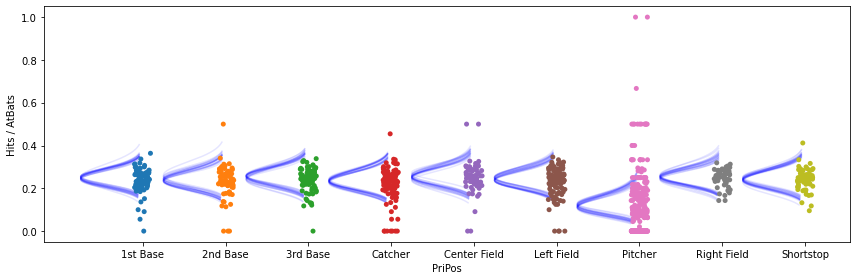

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
batting_df['Hits / AtBats'] = batting_df['Hits'] / batting_df['AtBats']
sns.stripplot(x='PriPos', y='Hits / AtBats', data=batting_df, ax=ax)

posterior = idata_binom_het.posterior
n_curves = 20

for i, pri_pos in enumerate(batting_df['PriPos'].cat.categories):
    omega = posterior['omega'].sel(pos=pri_pos).values.flatten()
    kappa = posterior['kappa'].sel(pos=pri_pos).values.flatten()

    curve_indices = np.random.choice(
        posterior.chain.size * posterior.draw.size,
        n_curves,
        replace=False,
    )

    for idx in curve_indices:
        rv = beta(omega[idx] * (kappa[idx] - 2) + 1,
                  (1 - omega[idx]) * (kappa[idx] - 2) + 1)
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 1000)
        xpdf = rv.pdf(yrange)
        xpdf *= 0.75 / np.max(xpdf)

        ax.plot(i - xpdf, yrange, c='b', alpha=.1)

fig.tight_layout()

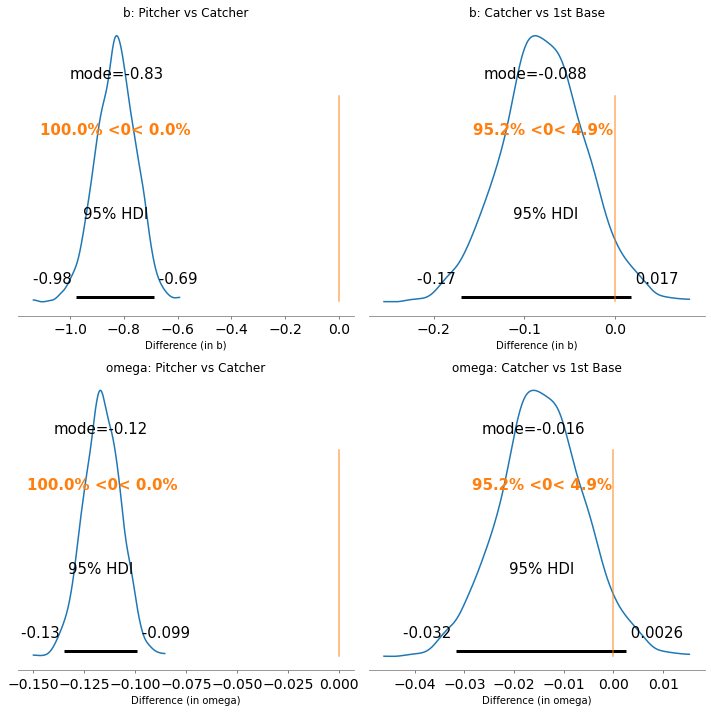

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

differences = [
    ('b', 'Pitcher', 'Catcher'),
    ('b', 'Catcher', '1st Base'),
    ('omega', 'Pitcher', 'Catcher'),
    ('omega', 'Catcher', '1st Base'),
]
for ax, (var, left_pos, right_pos) in zip(axes.flatten(), differences):
    left_val = posterior[var].sel(pos=left_pos).values
    right_val = posterior[var].sel(pos=right_pos).values
    diff = left_val - right_val

    az.plot_posterior(diff, point_estimate='mode',
                      hdi_prob=0.95, ref_val=0, ax=ax)
    ax.set_title(f'{var}: {left_pos} vs {right_pos}')
    ax.set_xlabel(f'Difference (in {var})')

fig.tight_layout()